# Allen-Cahn equation

## Problem setup
We will solve an Allen-Cahn equation:

$$
\frac{\partial u}{\partial t} = d\frac{\partial^2u}{\partial x^2} + 5(u - u^3), \quad x \in [-1, 1], \quad t \in [0, 1]
$$

The initial condition is defined as the following:
$$
u(x, 0) = x^2\cos(\pi x)
$$

And the boundary condition is defined:
$$
u(-1, t) = u(1, t) = -1
$$

The reference solution is [here](https://github.com/chaobrain/pinnx/blob/master/docs/dataset/Allen_Cahn.mat).

Because the Allen-Cahn equation has inconsistent units, so here we do not provide the physical meaning of the parameters.

## Implementation
This description goes through the implementation of a solver for the above described Allen-Cahn equation step-by-step.

First, Import the necessary library used for this project:

In [1]:
import brainstate as bst
import braintools
import brainunit as u
import numpy as np
from scipy.io import loadmat

from deepxde import pinnx

We then begin by defining a computational geometry and a time domain. We can use a built-in class `Interval` and `TimeDomain`, and we can combine both of the domains using `GeometryXTime`.

In [7]:
geom = pinnx.geometry.Interval(-1, 1)
timedomain = pinnx.geometry.TimeDomain(0, 1)
geomtime = pinnx.geometry.GeometryXTime(geom, timedomain).to_dict_point('x', 't')

Now, we express the PDE residual of the Allen-Cahn equation:

In [4]:
d = 0.001

@bst.compile.jit
def pde(x, out):
    jacobian = net.jacobian(x)
    hessian = net.hessian(x, xi='x', xj='x')
    dy_t = jacobian['u']['t']
    dy_xx = hessian['u']['x']['x']
    return dy_t - d * dy_xx - 5 * (out['u'] - out['u'] ** 3)

Next, we choose the network. Here, we use a fully connected neural network of depth 4 (i.e., 3 hidden layers) and width 20:

In [5]:
net = pinnx.nn.Model(
    pinnx.nn.DictToArray(x=None, t=None),
    pinnx.nn.FNN(
        [2] + [20] * 3 + [1],
        activation="tanh",
        output_transform=lambda x, y: u.math.expand_dims(
            x[..., 0] ** 2 * u.math.cos(np.pi * x[..., 0]) +
            x[..., 1] * (1 - x[..., 0] ** 2) * y,
            axis=-1
        )
    ),
    pinnx.nn.ArrayToDict(u=None)
)

The first argument to `pde` is a 2-dimensional vector where the first component(`x[:, 0]`) is `x`-coordinate and the second component (`x[:, 1]`) is the `t`-coordinate. The second argument is the network output, i.e., the solution `u(x, t)`, but here we use `y` as the name of the variable.

Now that we have specified the geometry and PDE residual, we can define the `TimePDE` problem as the following:

In [8]:
problem = pinnx.problem.TimePDE(
    geomtime,
    pde,
    [],
    net,
    num_domain=8000,
    num_boundary=400,
    num_initial=800
)

Now that we have defined the neural network, we build a `Model`, choose the optimizer and learning rate (`lr`), and train it for 15000 iterations:

In [9]:
trainer = pinnx.Trainer(problem)
trainer.compile(bst.optim.Adam(lr=1e-3)).train(iterations=15000)

Compiling trainer...
'compile' took 0.057796 s

Training trainer...

Step      Train loss                                 Test loss                                  Test metric 
0         [Array(1.2709892, dtype=float32)]          [Array(1.2709892, dtype=float32)]          []          
1000      [Array(0.5983757, dtype=float32)]          [Array(0.5983757, dtype=float32)]          []          
2000      [Array(0.5952873, dtype=float32)]          [Array(0.5952873, dtype=float32)]          []          
3000      [Array(0.5927927, dtype=float32)]          [Array(0.5927927, dtype=float32)]          []          
4000      [Array(0.58992064, dtype=float32)]         [Array(0.58992064, dtype=float32)]         []          
5000      [Array(0.58779794, dtype=float32)]         [Array(0.58779794, dtype=float32)]         []          
6000      [Array(0.5867402, dtype=float32)]          [Array(0.5867402, dtype=float32)]          []          
7000      [Array(0.5860185, dtype=float32)]          [Array

After we train the network using Adam, we continue to train the network using L-BFGS to achieve a smaller loss:

In [10]:
trainer.compile(bst.optim.LBFGS(lr=1e-3)).train(1000, display_every=200)

Compiling trainer...
'compile' took 0.198848 s

Training trainer...

Step      Train loss                                 Test loss                                  Test metric 
15000     [Array(0.5845136, dtype=float32)]          [Array(0.5845136, dtype=float32)]          []          
15200     [Array(0.5845137, dtype=float32)]          [Array(0.5845137, dtype=float32)]          []          
15400     [Array(0.5845137, dtype=float32)]          [Array(0.5845137, dtype=float32)]          []          
15600     [Array(0.5845136, dtype=float32)]          [Array(0.5845136, dtype=float32)]          []          
15800     [Array(0.58451355, dtype=float32)]         [Array(0.58451355, dtype=float32)]         []          
16000     [Array(0.58451355, dtype=float32)]         [Array(0.58451355, dtype=float32)]         []          

Best trainer at step 15800:
  train loss: 5.85e-01
  test loss: 5.85e-01
  test metric: []

'train' took 150.270458 s



We then save and plot the best trained result and the loss history of the model.

Saving loss history to /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/loss.dat ...
Saving checkpoint into /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/loss.dat
Saving training data to /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/train.dat ...
Saving checkpoint into /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/train.dat
Saving test data to /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/test.dat ...
Saving checkpoint into /Users/sichaohe/Documents/GitHub/pinnx/docs/examples-pinn-forward/test.dat


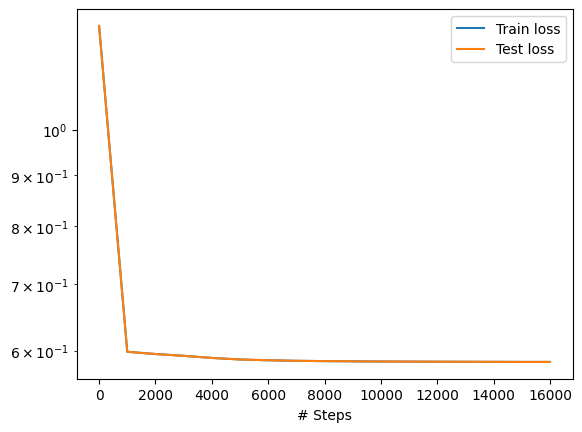

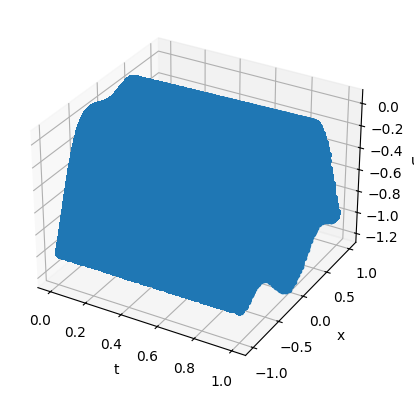

In [11]:
trainer.saveplot(issave=True, isplot=True)

Next, we load and prepare the dataset with gen_testdata(). Finally, we test the model and display a graph containing both training loss and testing loss over time. We also display a graph containing the predicted solution to the PDE.

In [12]:
def gen_testdata():
    data = loadmat("../dataset/Allen_Cahn.mat")

    t = data["t"]
    x = data["x"]
    u = data["u"]

    xx, tt = np.meshgrid(x, t)
    X = dict(x=np.ravel(xx), t=np.ravel(tt))
    return X, u.flatten()


X, y_true = gen_testdata()
y_pred = trainer.predict(X)
f = pde(X, y_pred)

print(y_true.shape, y_pred['u'].shape)
print("Mean residual:", u.math.mean(u.math.absolute(f)))
print("L2 relative error:", braintools.metric.l2_norm(y_true, y_pred['u']))

(20301,) (20301, 20301)
Mean residual: 0.5783491


AssertionError: predictions and targets must have the same shape.